# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

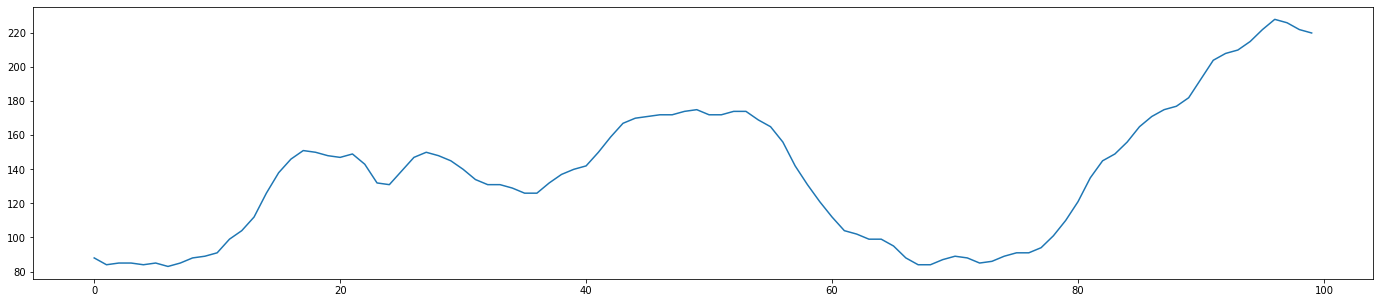

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value

fig = plt.figure(figsize=(24,5))
fig = plt.plot(df)

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(y):
    result = adfuller(y)
    labels = ["ADF Test Statistic", 'p-value', "#Lags Used", "No. of observations"]
    for value, label in zip(result, labels):
        print(label,':',str(value))
        
    if result[1] <= 0.05:
        print("Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary")
    else:
        print("Weak Evidence against null hypothesis(H1), time series has a unit root indicating it is non-stationary ")

adfuller_test(y)

ADF Test Statistic : -2.4642397172033688
p-value : 0.12441935447109453
#Lags Used : 3
No. of observations : 96
Weak Evidence against null hypothesis(H1), time series has a unit root indicating it is non-stationary 


The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

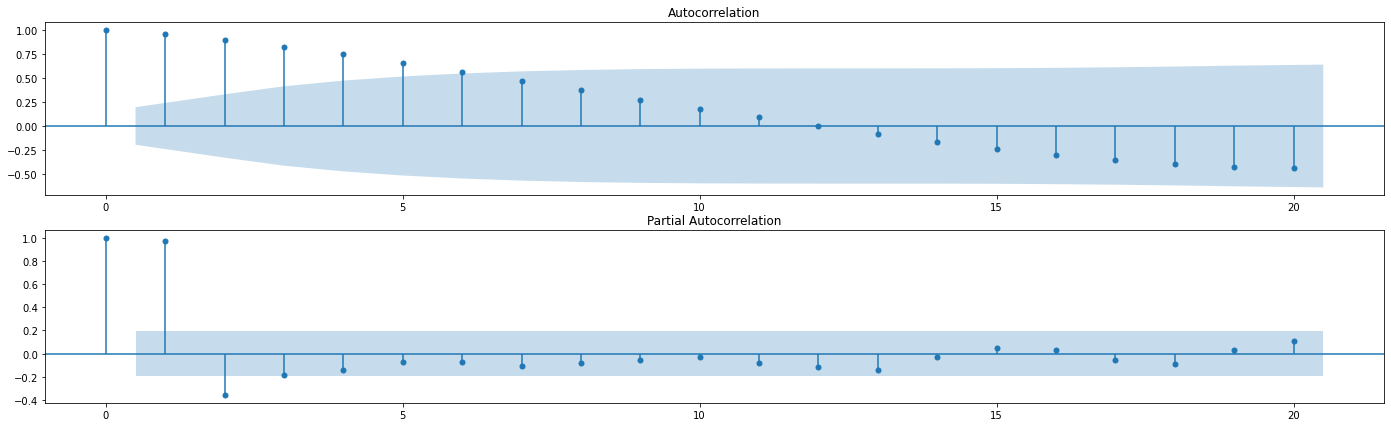

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(24,7))
ax1 = fig.add_subplot(211)
fig2 = plot_acf(y, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y, ax=ax2)

In [5]:
#df["Diff1"] = df["Sales"]- df["Sales"].shift()
df["Diff1"] = df["value"].diff()
df["Diff2"] = df["Diff1"].diff()

In [6]:
adfuller_test(df['Diff1'].dropna())

ADF Test Statistic : -2.7222384904429533
p-value : 0.07026846015272693
#Lags Used : 2
No. of observations : 96
Weak Evidence against null hypothesis(H1), time series has a unit root indicating it is non-stationary 


In [7]:
adfuller_test(df['Diff2'].dropna())

ADF Test Statistic : -9.929762173626015
p-value : 2.843428755547158e-17
#Lags Used : 1
No. of observations : 96
Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary


We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

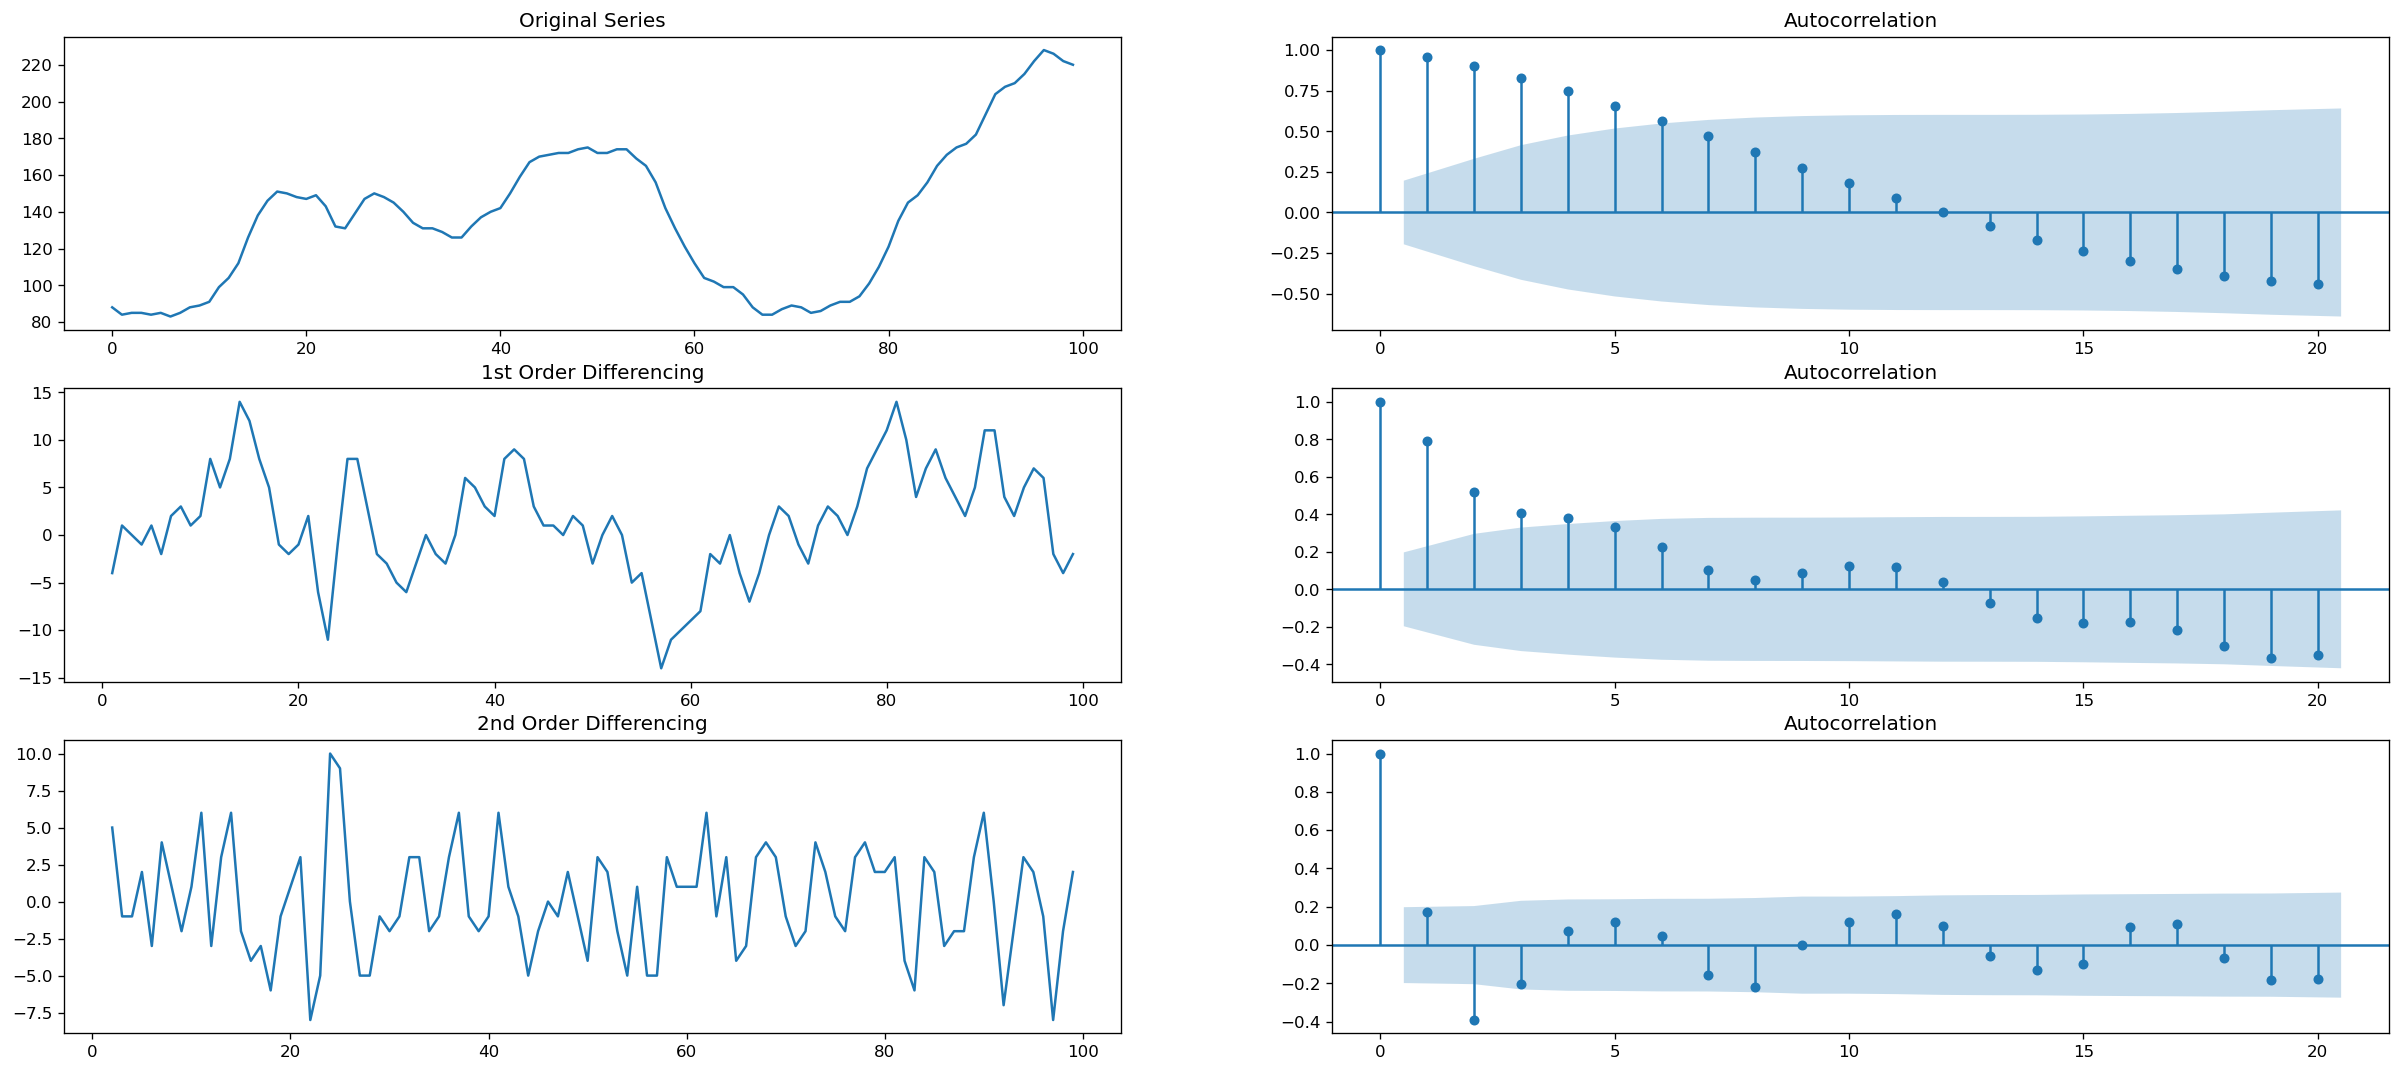

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(25,11), 'figure.dpi':120})
fig, ax = plt.subplots(3, 2, sharex=False)
ax[0,0].plot(df.value); ax[0,0].set_title('Original Series')
plot_acf(df.value, ax=ax[0,1])

ax[1,0].plot(df.value.diff()); ax[1,0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=ax[1,1])

ax[2,0].plot(df.value.diff().diff()); ax[2,0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=ax[2,1])

plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [9]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

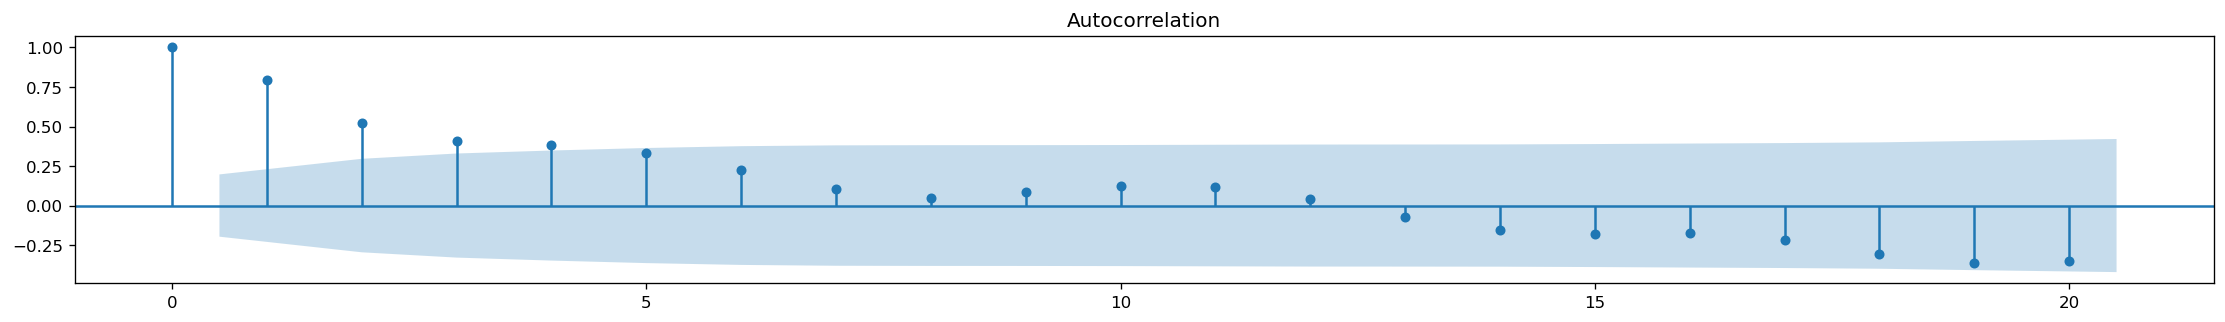

In [10]:
fig = plt.figure(figsize=(23,6))
ax1 = fig.add_subplot(211)
fig2 = plot_acf(y_diff, ax=ax1)

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

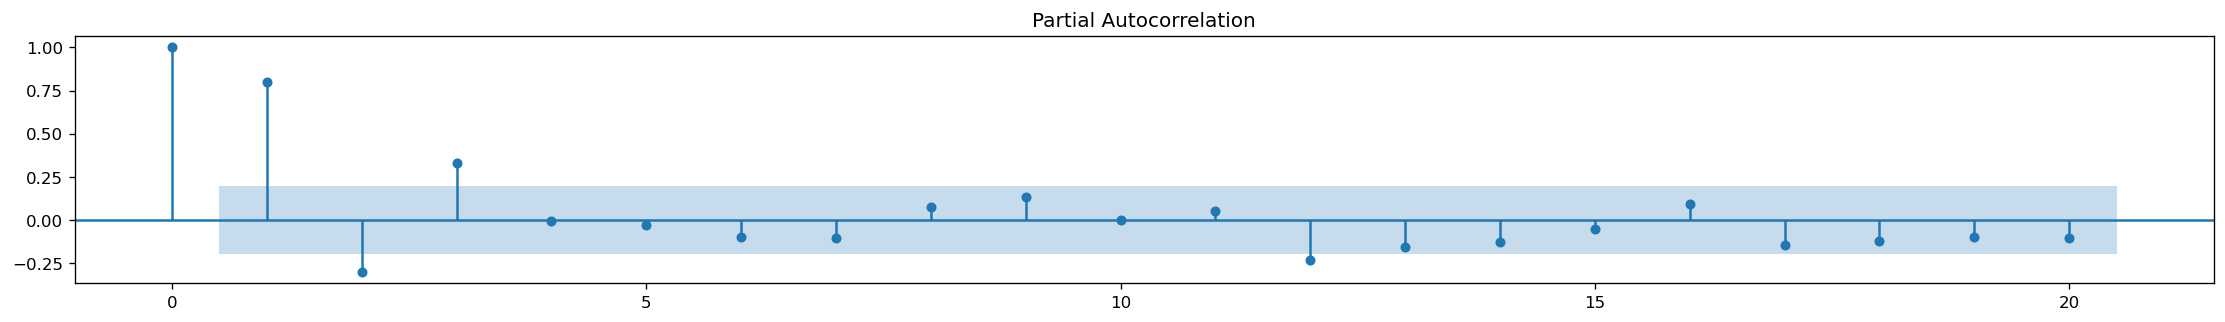

In [11]:
fig = plt.figure(figsize=(23,6))
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_diff, ax=ax2)

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y, order=(3,2,1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -250.356
Date:                Sun, 09 Jan 2022   AIC                            510.713
Time:                        14:33:45   BIC                            523.637
Sample:                             0   HQIC                           515.940
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1599      0.117      9.953      0.000       0.931       1.388
ar.L2         -0.6639      0.139     -4.760      0.000      -0.937      -0.391
ar.L3          0.3477      0.110      3.156      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

In [13]:
model = ARIMA(y, order=(1,1,0))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -262.619
Date:                Sun, 09 Jan 2022   AIC                            529.238
Time:                        14:33:52   BIC                            534.428
Sample:                             0   HQIC                           531.338
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8026      0.059     13.661      0.000       0.687       0.918
sigma2        11.6711      1.740      6.709      0.000       8.262      15.081
Ljung-Box (L1) (Q):                   5.50   Jarque-

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

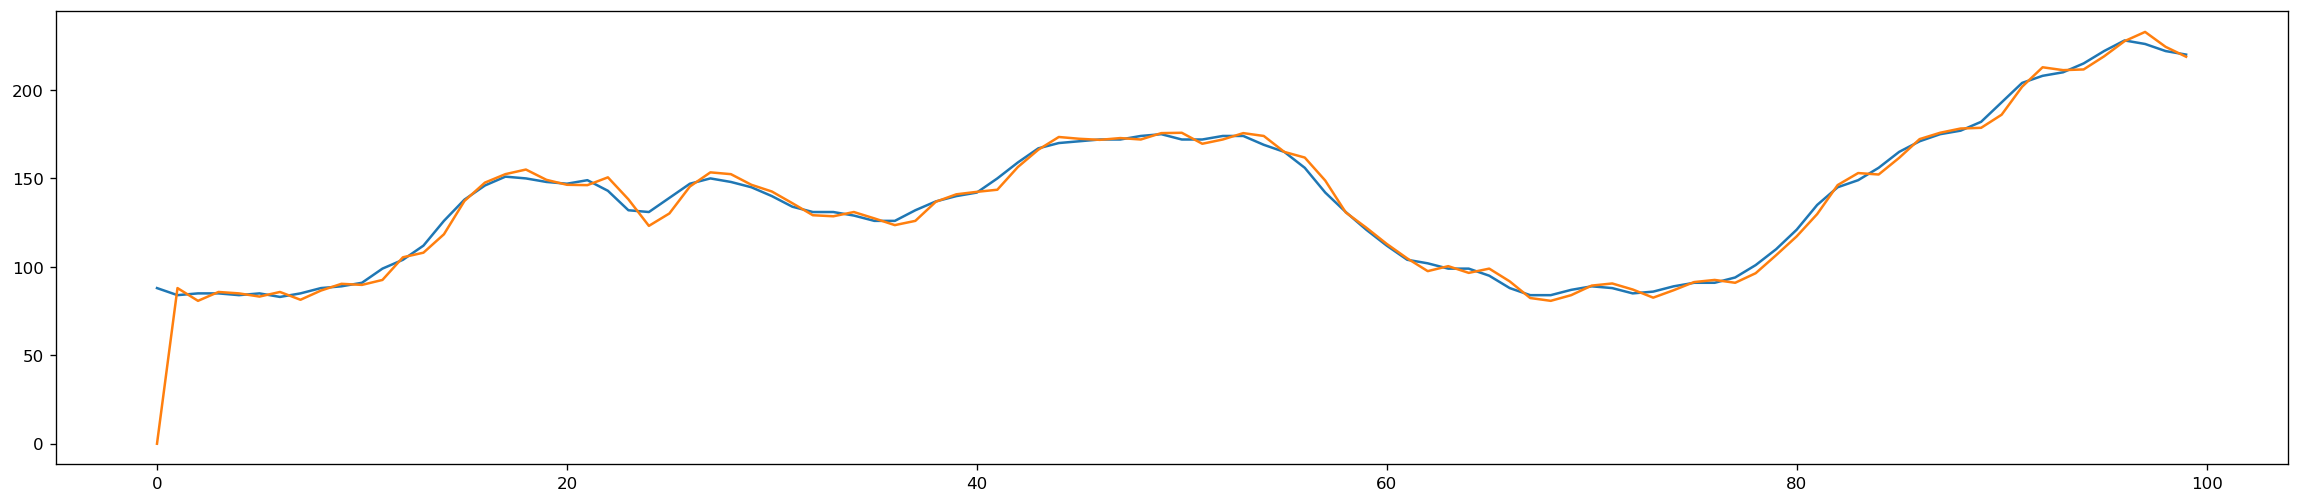

In [21]:
fig, ax = plt.subplots(figsize=(24,5))
ax = df.value.plot(ax=ax)
fig = plt.plot(model.predict(dynamic=False, ax=ax, plot_insample=False))
plt.show()

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

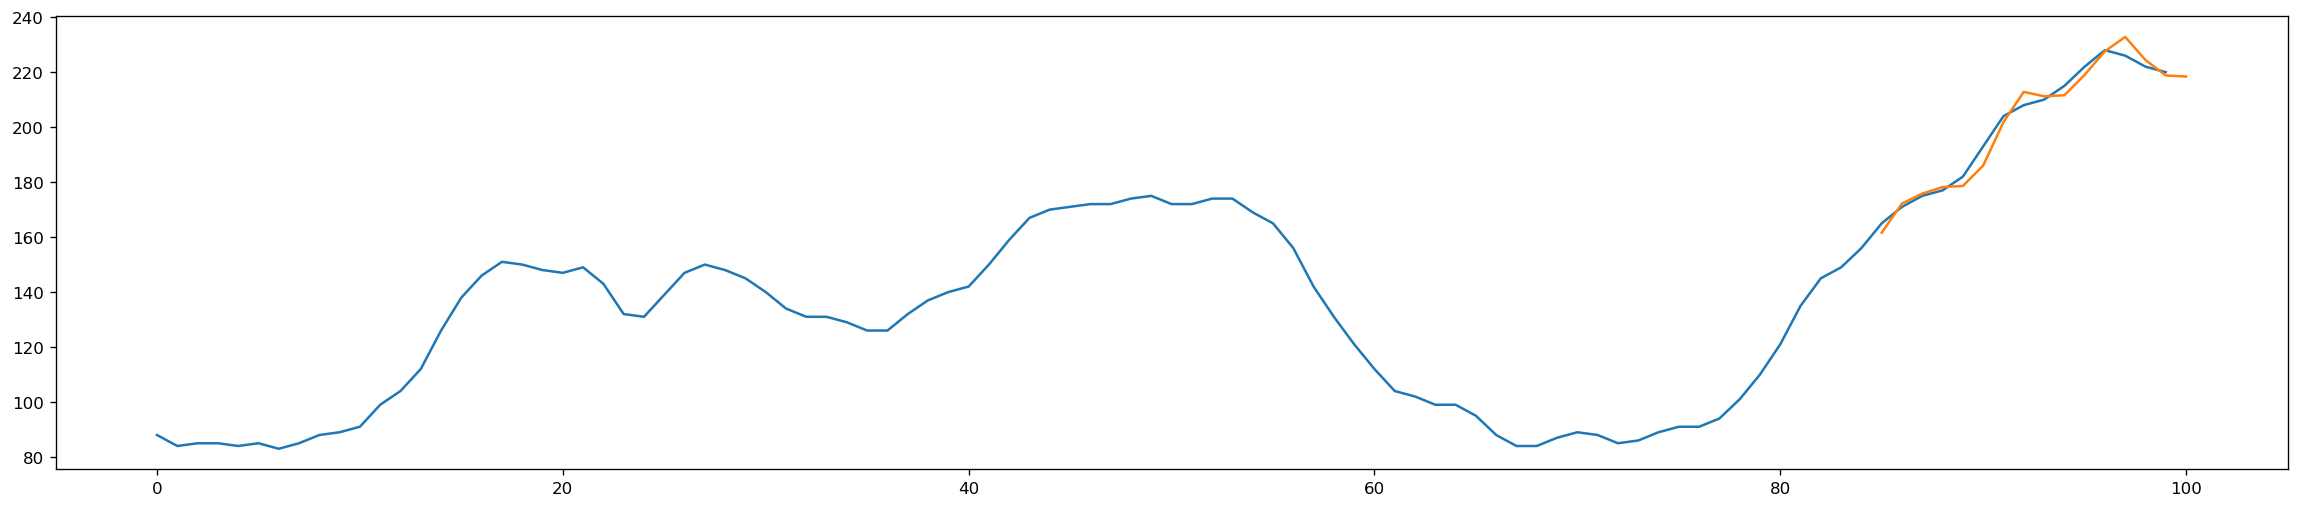

In [18]:
fig, ax = plt.subplots(figsize=(24,5))
ax = df.value.plot(ax=ax)
fig = plt.plot(model.predict(85, 100, dynamic=False, ax=ax, plot_insample=False))
plt.show()

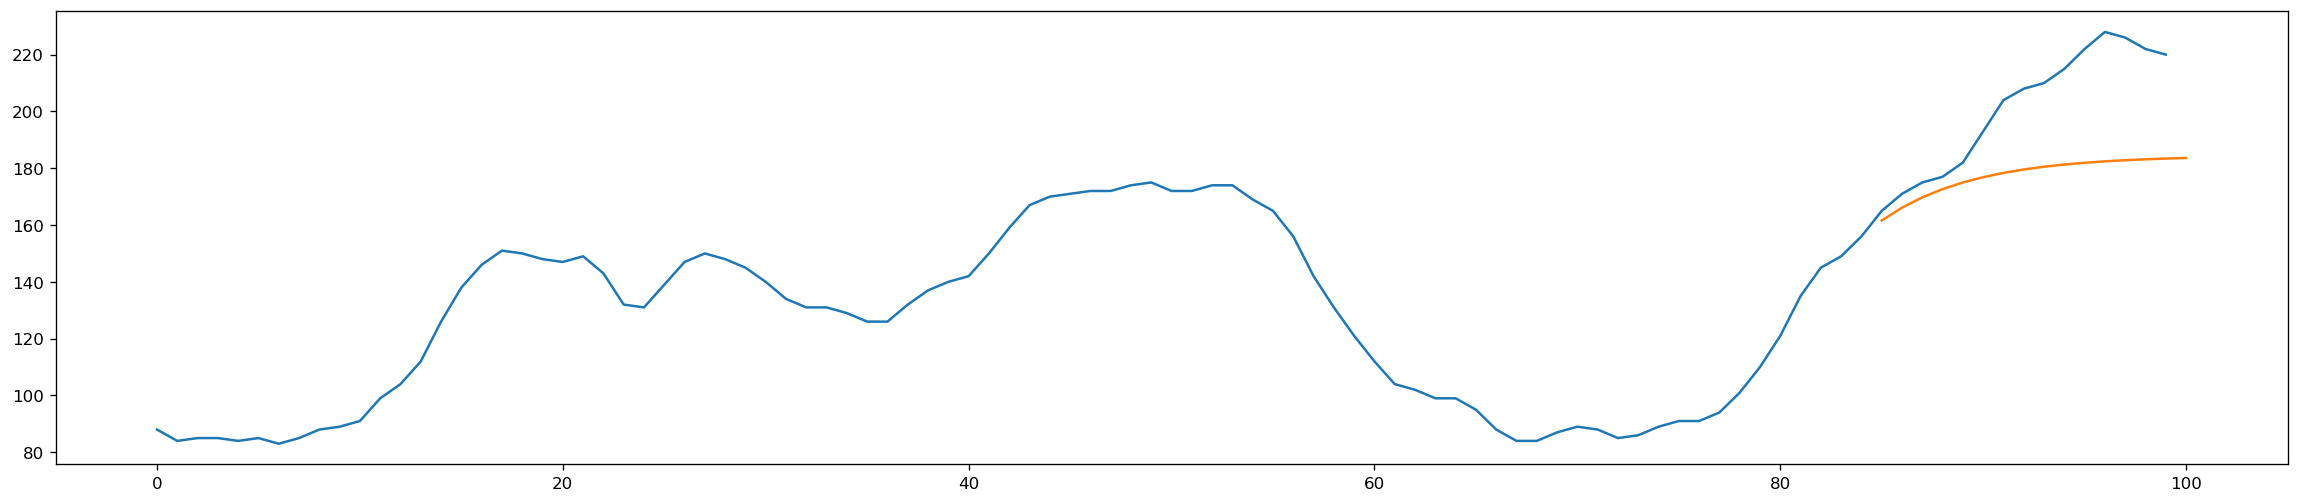

In [19]:
fig, ax = plt.subplots(figsize=(24,5))
ax = df.value.plot(ax=ax)
fig = plt.plot(model.predict(85, 100, dynamic=True, ax=ax, plot_insample=False))
plt.show()

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [20]:
from statsmodels.tsa.stattools import acf
train, test = df.value[:85], df.value[85:]

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [21]:
model = ARIMA(train, order=(1, 1, 0))  
model = model.fit()

forecast = model.forecast(15, alpha=0.05)  # 95% conf
forecast = pd.Series(forecast, index=test.index)

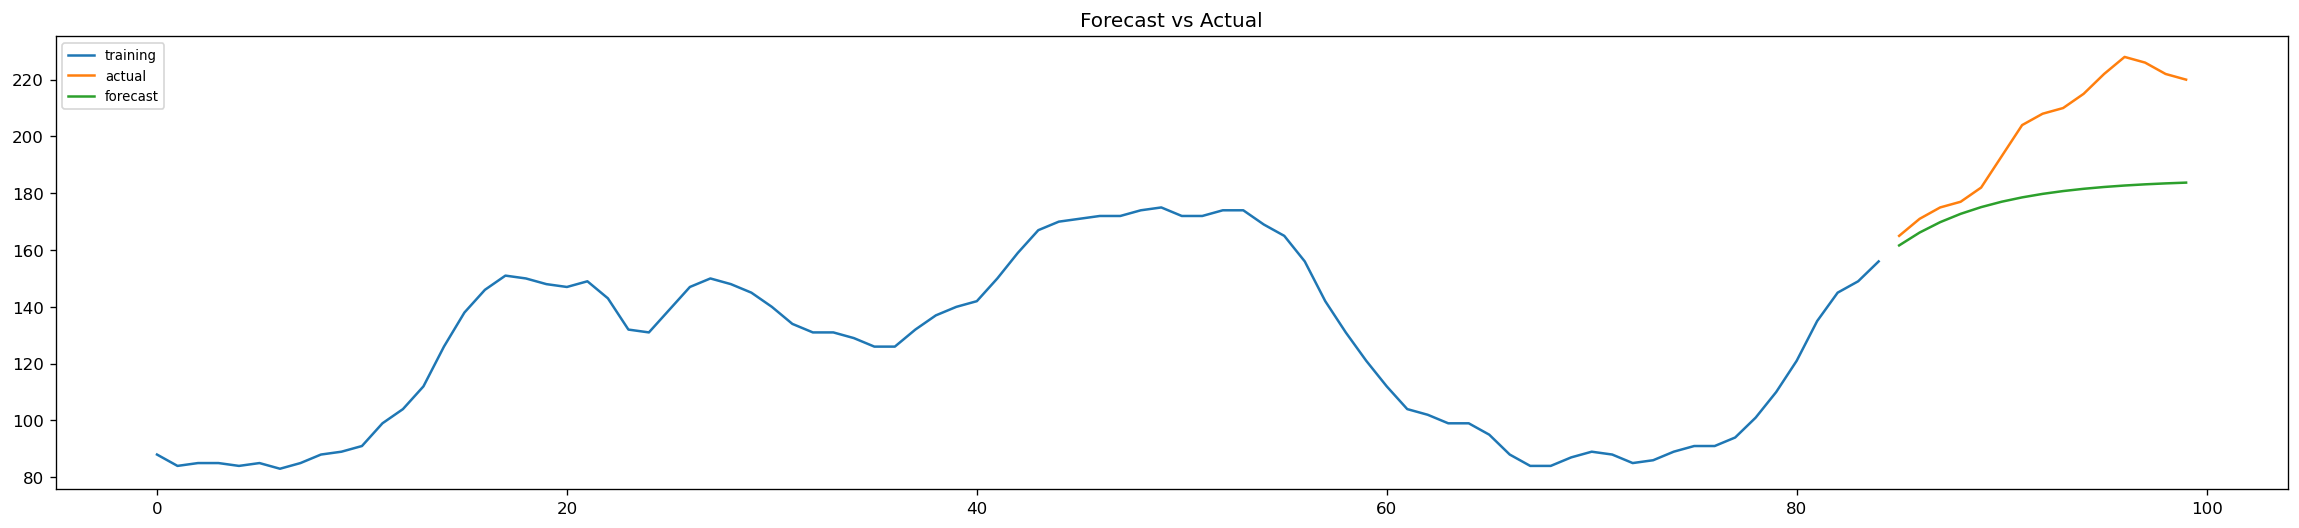

In [22]:
fig = plt.figure(figsize=(24,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast, label='forecast')

plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

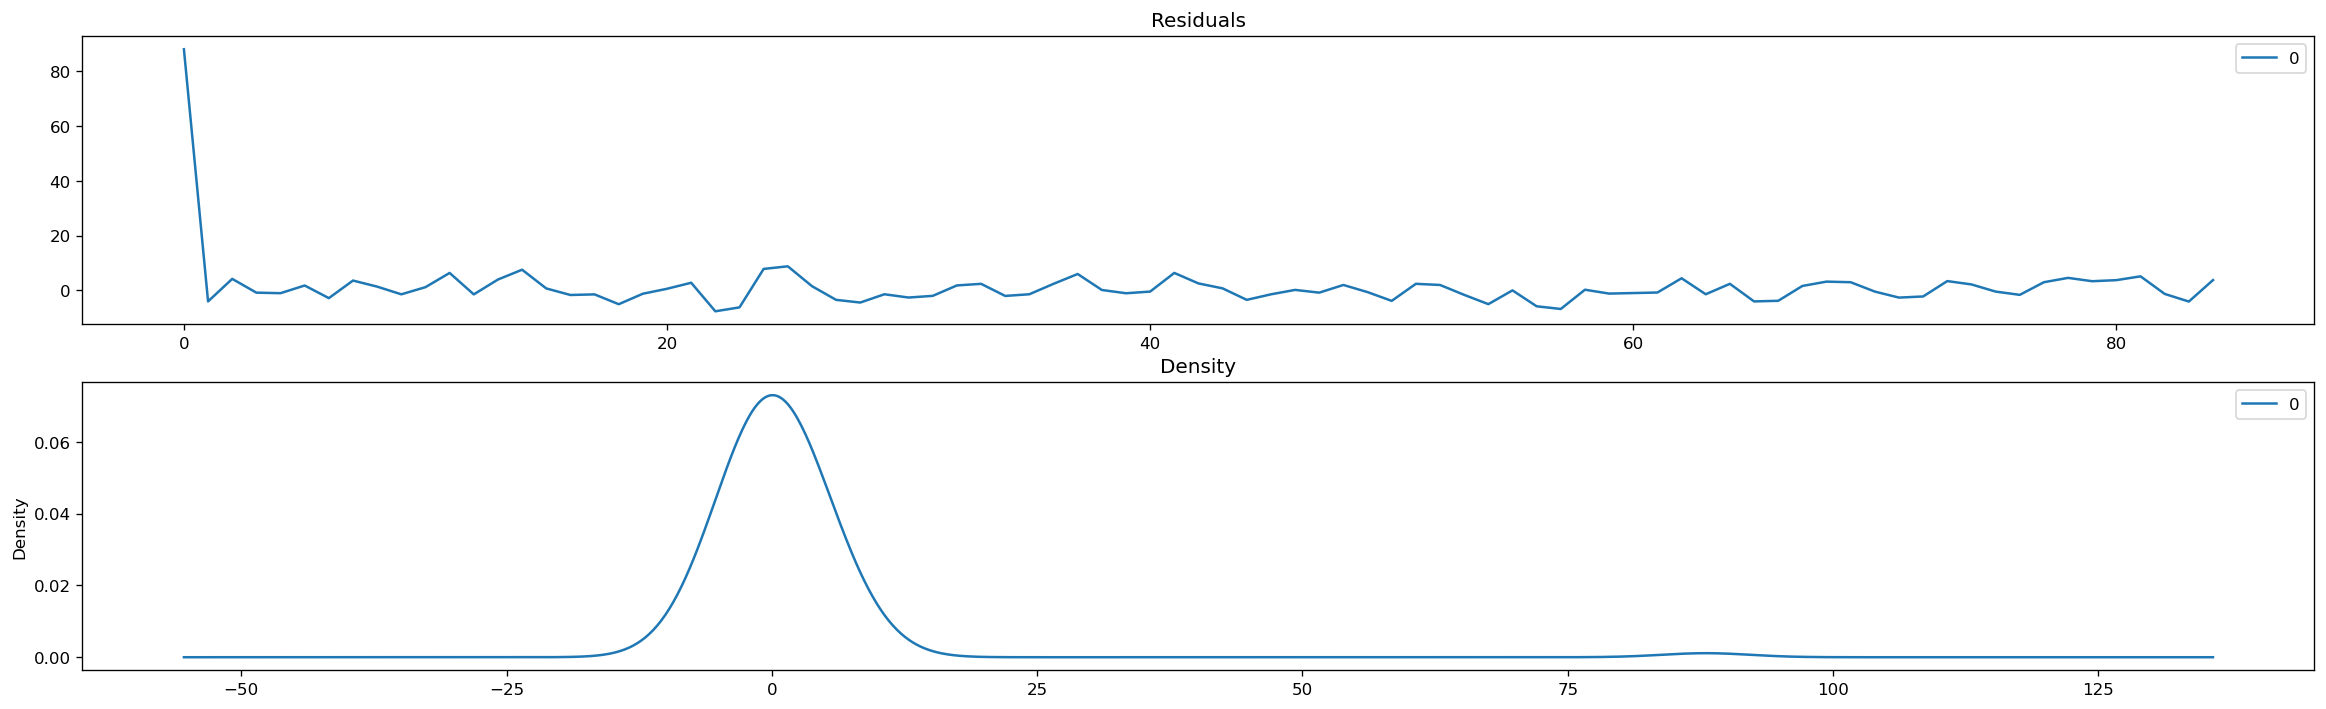

In [23]:
residuals = pd.DataFrame(model.resid)

fig = plt.figure(figsize=(24,7))
ax1 = fig.add_subplot(221)
fig2 = residuals.plot(title="Residuals", ax=ax1)
ax2 = fig.add_subplot(221)
fig = residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [24]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
    me = np.mean(y_pred - y_true)
    mae = np.mean(np.abs(y_pred - y_true))
    mpe = np.mean((y_pred - y_true)/y_true)
    rmse = np.mean((y_pred - y_true)**2)**.5
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between Actual and Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(y_pred-y_true, fft=False)[1]   # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [25]:
forecast_accuracy(forecast, test)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


{'mape': 0.11226615555405002,
 'me': -23.971276797609303,
 'mae': 23.971276797609303,
 'mpe': -0.11226615555405002,
 'rmse': 28.365648423161712,
 'acf1': 0.8717778408878368,
 'corr': 0.9491487657906766,
 'minmax': 0.11226615555404995}

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [26]:
import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1, test='adf', max_p=5, max_q=5, m=1,   # frequency of series
                      seasonal=False, start_P=0, D=0, d=None, # use adftest to find optimal 'd' 
                      trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [130]:
from sklearn.model_selection import TimeSeriesSplit

splits = TimeSeriesSplit(n_splits=5, test_size=10)
print(splits)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=10)


Observations: 60
Training Observations: 50
Testing Observations: 10
Observations: 70
Training Observations: 60
Testing Observations: 10
Observations: 80
Training Observations: 70
Testing Observations: 10
Observations: 90
Training Observations: 80
Testing Observations: 10
Observations: 100
Training Observations: 90
Testing Observations: 10


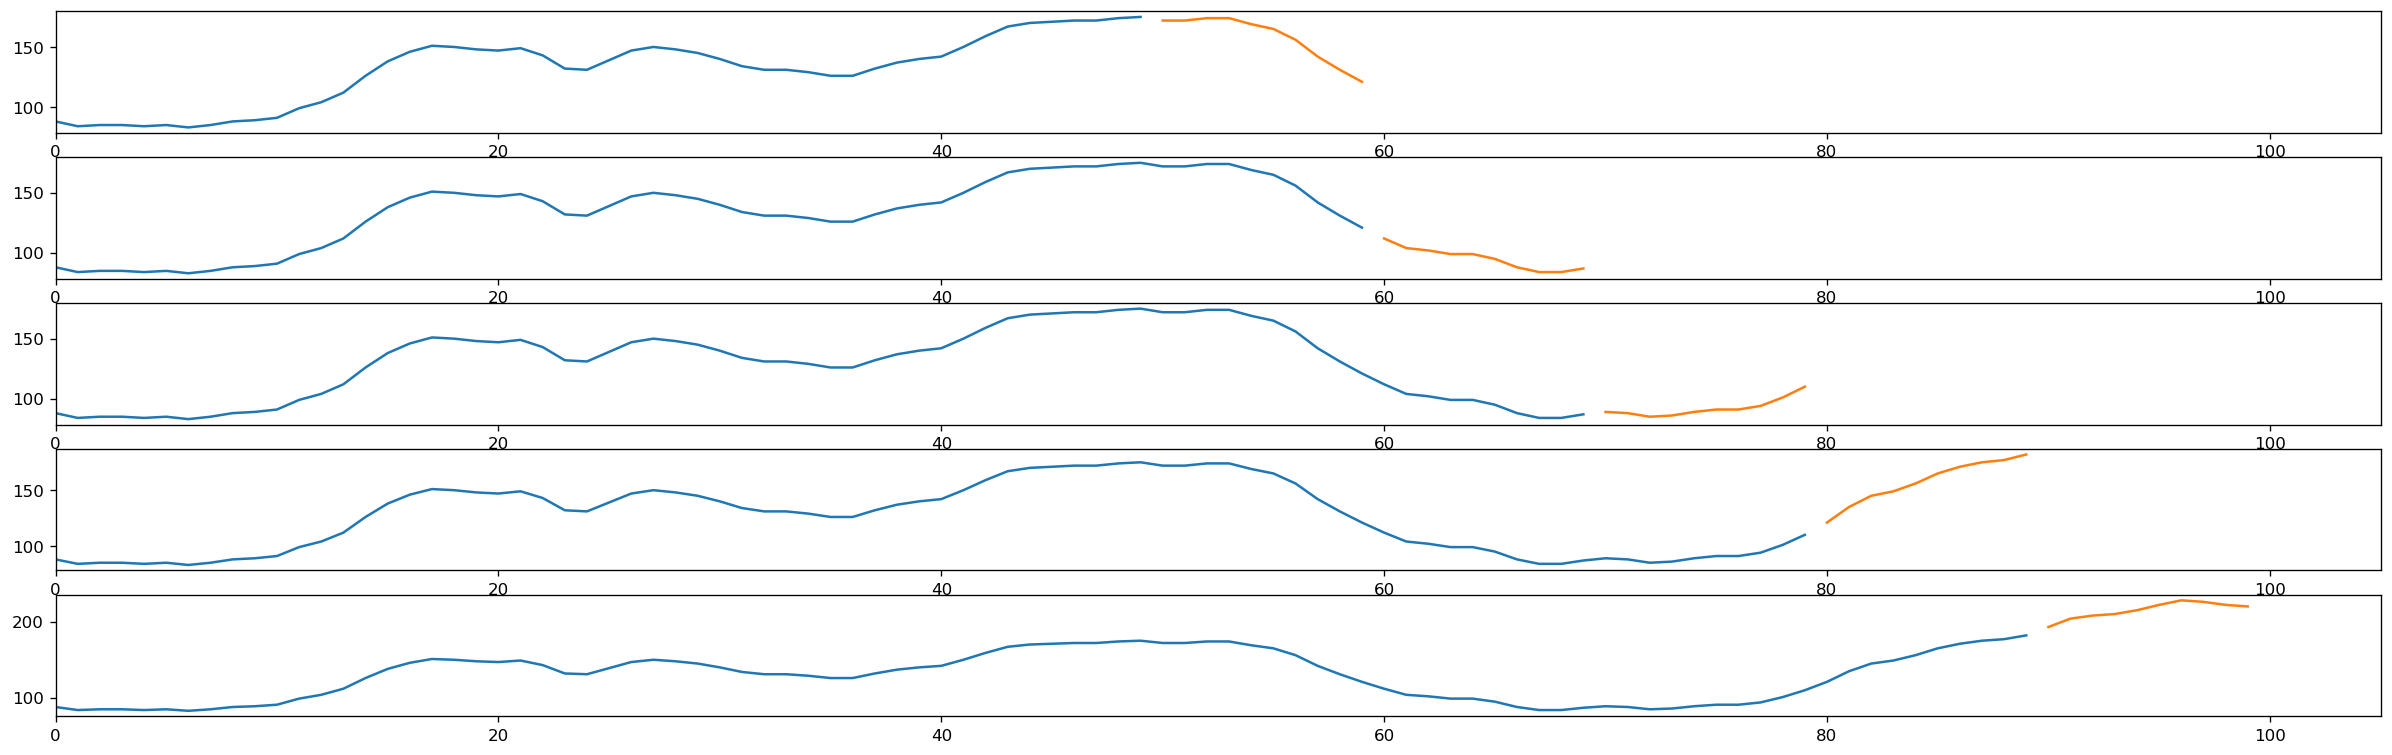

In [133]:
X = df.value

plt.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train, test = X[train_index], X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    #print("TRAIN:", train_index, "TEST:", test_index)
    ax1 = plt.subplot(710 + index)
    ax1.set_xlim([0, 105])
    ax1.plot(train)
    ax1.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()